In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

# ============================================================
# DEVICE
# ============================================================

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================================
# 0. Dataset (MNIST 7 vs 9)
# ============================================================

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

X, y = [], []
for img, label in mnist_train:
    if label in [7, 9]:
        arr = img.numpy().squeeze()
        arr = arr[2:-2, 2:-2]            # crop to 24x24
        X.append(arr.flatten().astype(np.float32))
        y.append(+1 if label == 7 else -1)

X = np.array(X)
y = np.array(y)

print("Total MNIST(7 vs 9) samples:", len(y))

# ============================================================
# 1. GPU kernels
# ============================================================

def gaussian_kernel(X, Y, sigma=35.0):
    X = X.float()
    Y = Y.float()
    X_norm = (X * X).sum(dim=1, keepdim=True)
    Y_norm = (Y * Y).sum(dim=1, keepdim=True).T
    XY = X @ Y.T
    dist2 = X_norm + Y_norm - 2 * XY
    return torch.exp(-dist2 / (2 * sigma * sigma))

def laplace_kernel(X, Y, sigma=35.0):
    X = X.float()
    Y = Y.float()
    X_norm2 = (X * X).sum(dim=1, keepdim=True)
    Y_norm2 = (Y * Y).sum(dim=1, keepdim=True).T
    XY = X @ Y.T
    dist2 = X_norm2 + Y_norm2 - 2 * XY
    dist2 = torch.clamp(dist2, min=0.0)
    return torch.exp(-torch.sqrt(dist2) / sigma)

import torch
import math

def nngp_erf_kernel(X, Y):
    """
    NNGP kernel for single hidden layer NN with erf activation,
    assuming sigma_b = 1, sigma_w = 1/d.

    X: [n, d] tensor
    Y: [m, d] tensor
    Returns: [n, m] kernel matrix
    """

    X = X.float()
    Y = Y.float()

    n, d = X.shape
    m, _ = Y.shape

    sigma_b = 1.0
    sigma_w = 1.0 / d

    # Compute inner products
    XY = X @ Y.T            # [n, m]
    XX = (X * X).sum(dim=1, keepdim=True)  # [n,1]
    YY = (Y * Y).sum(dim=1, keepdim=True).T  # [1,m]

    # Compute the augmented covariance terms
    # a = x̃ᵀ Σ x = 1 + (1/d) * ||x||^2
    a_X = sigma_b**2 + sigma_w * XX         # [n,1]
    a_Y = sigma_b**2 + sigma_w * YY         # [1,m]

    # cross term c = x̃ᵀ Σ ỹ = 1 + (1/d) * xᵀy
    c_XY = sigma_b**2 + sigma_w * XY        # [n,m]

    # Normalization denominator:
    denom = torch.sqrt((1 + 2*a_X) * (1 + 2*a_Y))  # [n,m]

    # Argument of arcsin:
    arg = 2 * c_XY / denom

    # Clamp for numerical safety
    arg = torch.clamp(arg, -1.0, 1.0)

    # Final kernel
    K = (2.0 / math.pi) * torch.asin(arg)
    return K

def linear_kernel(X, Y):
    """
    Linear kernel:
        K(x, y) = x^T y

    X: [n, d]
    Y: [m, d]
    Returns: [n, m] kernel matrix
    """
    X = X.float()
    Y = Y.float()
    return X @ Y.T

def matern32_kernel(X, Y, sigma=10.0):
    """
    Matérn kernel with ν = 3/2 (a.k.a. ν = 1.5):
    
        K(x,y) = (1 + sqrt(3)*d/sigma) * exp(-sqrt(3)*d/sigma)
    
    where d = ||x - y||_2.

    X: [n, d] tensor
    Y: [m, d] tensor
    Returns: [n, m] tensor
    """
    X = X.float()
    Y = Y.float()

    # Compute pairwise squared distances
    X_norm2 = (X ** 2).sum(dim=1, keepdim=True)       # [n,1]
    Y_norm2 = (Y ** 2).sum(dim=1, keepdim=True).T     # [1,m]

    XY = X @ Y.T                                      # [n,m]
    dist2 = X_norm2 + Y_norm2 - 2.0 * XY
    dist2 = torch.clamp(dist2, min=0.0)

    # Convert to Euclidean distance
    dist = torch.sqrt(dist2)

    # Matern 3/2 kernel formula
    sqrt3 = np.sqrt(3.0)
    scaled = sqrt3 * dist / sigma
    return (1.0 + scaled) * torch.exp(-scaled)


# ============================================================
# 2. ConditionalKRR (unchanged)
# ============================================================

class ConditionalKRR:
    def __init__(self, X_train, y_train, kernel, lam=1e-4):
        self.X_train = X_train.to(device)
        self.y_train = y_train.to(device)
        self.kernel  = kernel
        self.lam     = lam

        K = kernel(self.X_train, self.X_train)
        K = 0.5 * (K + K.T)
        self.K_train = K

        eigvals, eigvecs = torch.linalg.eigh(K)
        idx = torch.argsort(eigvals, descending=True)
        self.eigvals = eigvals[idx]
        self.V       = eigvecs[:, idx].contiguous()

    def residual_kernel(self, X, Y, k):
        X = X.to(device)
        Y = Y.to(device)
        K_XY = self.kernel(X, Y)
        if k == 0:
            return K_XY

        N = self.X_train.shape[0]
        V_k = self.V[:, :k]
        mu_k = self.eigvals[:k]

        inv_lam = 1.0 / mu_k
        V_scaled = V_k * inv_lam.view(1, -1)

        K_XU = self.kernel(X, self.X_train)
        K_YU = self.kernel(Y, self.X_train)
        K_UY = K_YU.T
        K_UU = self.K_train

        Pi_XU = (K_XU @ V_scaled) @ V_k.T
        Pi_YU = (K_YU @ V_scaled) @ V_k.T

        T1 = Pi_XU @ K_UY
        T2 = K_XU @ Pi_YU.T
        T3 = Pi_XU @ K_UU @ Pi_YU.T

        return K_XY - T1 - T2 + T3

    def fit(self, k):
        self.k = k
        N = self.X_train.shape[0]
        y = self.y_train

        if k == 0:
            self.c_unpen = torch.zeros_like(y)
        else:
            V_k = self.V[:, :k]
            mu_k = self.eigvals[:k]
            alpha_y = V_k.T @ y
            weights = alpha_y / mu_k
            self.c_unpen = V_k @ weights

        r = y - (self.K_train @ self.c_unpen)

        K_res = self.residual_kernel(self.X_train, self.X_train, k)
        A = K_res + N * self.lam * torch.eye(N, device=device)
        self.alpha = torch.linalg.solve(A, r)

        return self

    def predict(self, X_new):
        X_new = X_new.to(device)
        f_unpen = self.kernel(X_new, self.X_train) @ self.c_unpen
        K_res_x = self.residual_kernel(X_new, self.X_train, self.k)
        return f_unpen + (K_res_x @ self.alpha)

Using device: cuda:0
Total MNIST(7 vs 9) samples: 12214



Running 10-fold CV ...

=== Fold 1/10 ===
   k=  0, MSE=0.465375
   k=500, MSE=0.154119
   k=1000, MSE=0.130410
   k=1500, MSE=0.121281
   k=2000, MSE=0.119215
   k=2500, MSE=0.116145
   k=3000, MSE=0.114164
   k=3500, MSE=0.112516
   k=4000, MSE=0.111268
   k=4500, MSE=0.110727
   k=5000, MSE=0.109900
   k=5500, MSE=0.109168
   k=6000, MSE=0.108346
   k=6500, MSE=0.108044
   k=7000, MSE=0.107475
   k=7500, MSE=0.106917
   k=8000, MSE=0.106601
   k=8500, MSE=0.106415
   k=9000, MSE=0.106344
   k=9500, MSE=0.106262
   k=10000, MSE=0.106206
   k=10500, MSE=0.106090
   k=11000, MSE=0.105984

=== Fold 2/10 ===
   k=  0, MSE=0.448722
   k=500, MSE=0.144633
   k=1000, MSE=0.121242
   k=1500, MSE=0.111534
   k=2000, MSE=0.109065
   k=2500, MSE=0.107094
   k=3000, MSE=0.105401
   k=3500, MSE=0.104183
   k=4000, MSE=0.103518
   k=4500, MSE=0.102143
   k=5000, MSE=0.101513
   k=5500, MSE=0.101025
   k=6000, MSE=0.100444
   k=6500, MSE=0.099777
   k=7000, MSE=0.099531
   k=7500, MSE=0.098963
   

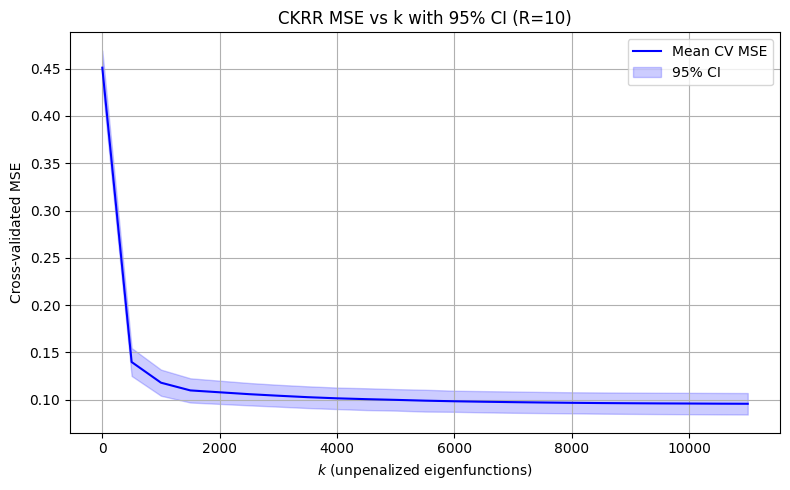

In [8]:
R = 10                    # number of folds
max_k = 11000
k_grid = list(range(0, max_k+1, 500))

mse_matrix = np.zeros((R, len(k_grid)), float)

kf = KFold(n_splits=R, shuffle=True, random_state=12345)

print(f"\nRunning {R}-fold CV ...")

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold_idx+1}/{R} ===")

    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_val_cv   = X[val_idx]
    y_val_cv   = y[val_idx]

    # Standardize per fold
    scaler_f = StandardScaler().fit(X_train_cv)
    Xt = scaler_f.transform(X_train_cv)
    Xv = scaler_f.transform(X_val_cv)

    Xt_t = torch.tensor(Xt, dtype=torch.float32, device=device)
    Xv_t = torch.tensor(Xv, dtype=torch.float32, device=device)
    yt_t = torch.tensor(y_train_cv, dtype=torch.float32, device=device)
    yv_t = torch.tensor(y_val_cv, dtype=torch.float32, device=device)

    # Evaluate CKRR for all k
    model_f = ConditionalKRR(Xt_t, yt_t, matern32_kernel, lam=1e-2)

    for i, k in enumerate(k_grid):
        model_f.fit(k)
        with torch.no_grad():
            pred = model_f.predict(Xv_t)
            mse = ((pred - yv_t)**2).mean().item()
        mse_matrix[fold_idx, i] = mse
        print(f"   k={k:3d}, MSE={mse:.6f}")

# ============================================================
# 4. Compute mean + 95% confidence intervals
# ============================================================

mse_mean = mse_matrix.mean(axis=0)
mse_std  = mse_matrix.std(axis=0, ddof=1)
ci_95 = 1.96 * mse_std 

# ============================================================
# 5. Plot
# ============================================================

plt.figure(figsize=(8,5))
plt.plot(k_grid, mse_mean, color='blue', label="Mean CV MSE")
plt.fill_between(k_grid,
                 mse_mean - ci_95,
                 mse_mean + ci_95,
                 color='blue', alpha=0.2,
                 label="95% CI")
plt.xlabel("$k$ (unpenalized eigenfunctions)")
plt.ylabel("Cross-validated MSE")
plt.title(f"CKRR MSE vs k with 95% CI (R={R})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

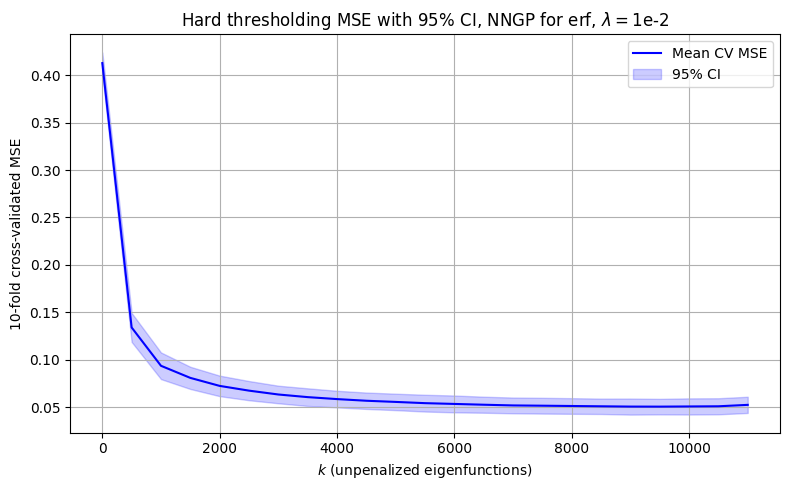

In [26]:
plt.figure(figsize=(8,5))
plt.plot(k_grid, mse_mean, color='blue', label="Mean CV MSE")
plt.fill_between(k_grid,
                 mse_mean - ci_95,
                 mse_mean + ci_95,
                 color='blue', alpha=0.2,
                 label="95% CI")
plt.xlabel("$k$ (unpenalized eigenfunctions)")
plt.ylabel("10-fold cross-validated MSE")
plt.title("Hard thresholding MSE with 95% CI, NNGP for erf, $\lambda = $1e-2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("hard_nngp.png", dpi=600, bbox_inches="tight")
plt.show()


Running 10-fold CV ...

=== Fold 1/10 ===
  Best λ = 1e-12
   k=  0, MSE=0.072202
   k= 25, MSE=0.072203
   k= 50, MSE=0.072198
   k= 75, MSE=0.072183
   k=100, MSE=0.072220
   k=125, MSE=0.081691
   k=150, MSE=0.072205
   k=175, MSE=0.072180
   k=200, MSE=0.072241

=== Fold 2/10 ===
  Best λ = 1e-12
   k=  0, MSE=0.064471
   k= 25, MSE=0.064465
   k= 50, MSE=0.064469
   k= 75, MSE=0.064497
   k=100, MSE=0.064442
   k=125, MSE=0.064888
   k=150, MSE=0.064390
   k=175, MSE=0.064540
   k=200, MSE=0.065403

=== Fold 3/10 ===
  Best λ = 1e-11
   k=  0, MSE=0.060330
   k= 25, MSE=0.060316
   k= 50, MSE=0.060170
   k= 75, MSE=0.060382
   k=100, MSE=0.060343
   k=125, MSE=0.060372
   k=150, MSE=0.060351
   k=175, MSE=0.060358
   k=200, MSE=0.060770

=== Fold 4/10 ===
  Best λ = 1e-12
   k=  0, MSE=0.068087
   k= 25, MSE=0.068090
   k= 50, MSE=0.068036
   k= 75, MSE=0.068064
   k=100, MSE=0.068107
   k=125, MSE=0.068124
   k=150, MSE=0.071098
   k=175, MSE=0.068265
   k=200, MSE=0.068057

===

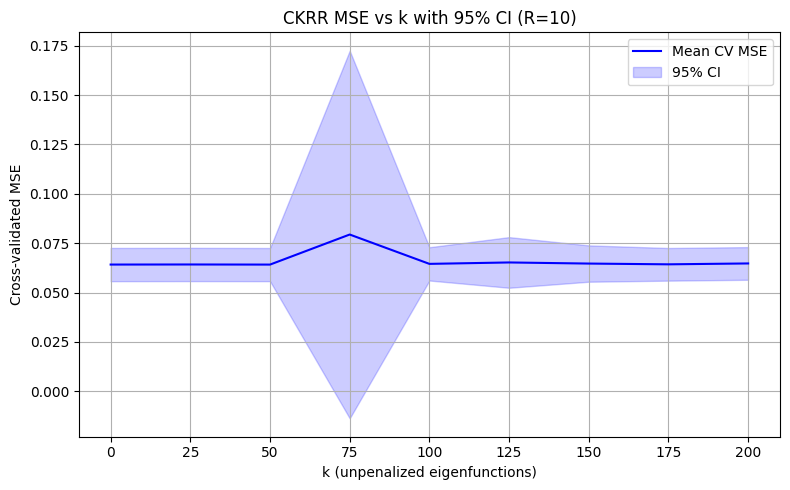

In [5]:
R = 10                    # number of folds
max_k = 200
k_grid = list(range(0, max_k+1, 25))
lambda_candidates = [1e-10, 1e-11, 1e-12, 1e-13]

mse_matrix = np.zeros((R, len(k_grid)), float)

kf = KFold(n_splits=R, shuffle=True, random_state=12345)

print(f"\nRunning {R}-fold CV ...")

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold_idx+1}/{R} ===")

    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_val_cv   = X[val_idx]
    y_val_cv   = y[val_idx]

    # Standardize per fold
    scaler_f = StandardScaler().fit(X_train_cv)
    Xt = scaler_f.transform(X_train_cv)
    Xv = scaler_f.transform(X_val_cv)

    Xt_t = torch.tensor(Xt, dtype=torch.float32, device=device)
    Xv_t = torch.tensor(Xv, dtype=torch.float32, device=device)
    yt_t = torch.tensor(y_train_cv, dtype=torch.float32, device=device)
    yv_t = torch.tensor(y_val_cv, dtype=torch.float32, device=device)

    # Tune λ at k=0
    best_lam = None
    best_val = float("inf")
    for lam in lambda_candidates:
        model_tmp = ConditionalKRR(Xt_t, yt_t, laplace_kernel, lam=lam)
        model_tmp.fit(0)
        with torch.no_grad():
            pred = model_tmp.predict(Xv_t)
            mse = ((pred - yv_t)**2).mean().item()
        if mse < best_val:
            best_val = mse
            best_lam = lam

    print("  Best λ =", best_lam)

    # Evaluate CKRR for all k
    model_f = ConditionalKRR(Xt_t, yt_t, laplace_kernel, lam=best_lam)

    for i, k in enumerate(k_grid):
        model_f.fit(k)
        with torch.no_grad():
            pred = model_f.predict(Xv_t)
            mse = ((pred - yv_t)**2).mean().item()
        mse_matrix[fold_idx, i] = mse
        print(f"   k={k:3d}, MSE={mse:.6f}")

# ============================================================
# 4. Compute mean + 95% confidence intervals
# ============================================================

mse_mean = mse_matrix.mean(axis=0)
mse_std  = mse_matrix.std(axis=0, ddof=1)
ci_95 = 1.96 * mse_std 

# ============================================================
# 5. Plot
# ============================================================

plt.figure(figsize=(8,5))
plt.plot(k_grid, mse_mean, color='blue', label="Mean CV MSE")
plt.fill_between(k_grid,
                 mse_mean - ci_95,
                 mse_mean + ci_95,
                 color='blue', alpha=0.2,
                 label="95% CI")
plt.xlabel("k (unpenalized eigenfunctions)")
plt.ylabel("Cross-validated MSE")
plt.title(f"CKRR MSE vs k with 95% CI (R={R})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

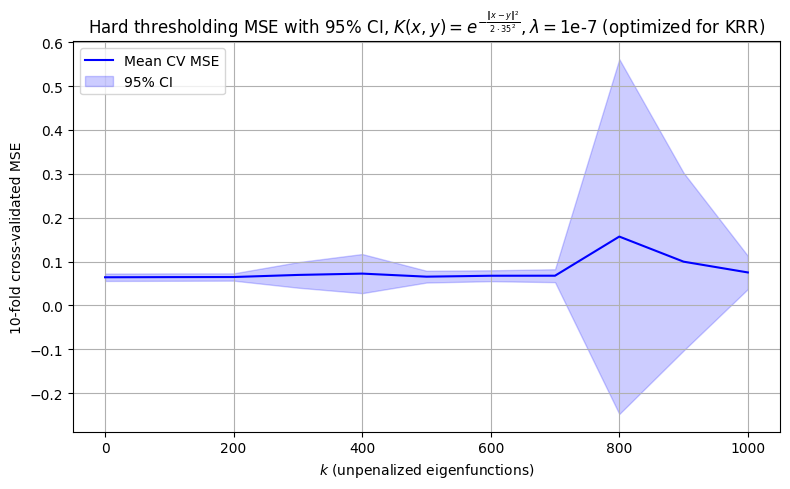

In [3]:
plt.figure(figsize=(8,5))
plt.plot(k_grid[:16], mse_mean[:16], color='blue', label="Mean CV MSE")
plt.fill_between(k_grid[:16],
                 mse_mean[:16] - ci_95[:16],
                 mse_mean[:16] + ci_95[:16],
                 color='blue', alpha=0.2,
                 label="95% CI")
plt.xlabel("$k$ (unpenalized eigenfunctions)")
plt.ylabel("10-fold cross-validated MSE")
plt.title("Hard thresholding MSE with 95% CI, $K(x,y)=e^{-\\frac{\\|x-y\\|^2}{2\cdot 35^2}},\lambda = $1e-7 (optimized for KRR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("optimized_hard_laplace.png", dpi=600, bbox_inches="tight")
plt.show()

In [4]:
R = 10  # number of repetitions

lambda_grid = [
      1e-6, 1e-7, 1e-8, 1e-9, 1e-10
]

test_mse_list = []

print(f"Running {R} repetitions for KRR (k=0) with λ tuning...")
print("Lambda grid:", lambda_grid)

for r in range(R):
    print(f"\n===== Repetition {r+1}/{R} =====")

    # ----------------------------------------------------------------------
    # Random split: 60% train / 20% valid / 20% test
    # ----------------------------------------------------------------------
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=None, stratify=y
    )
    X_train_full, X_valid_full, y_train, y_valid = train_test_split(
        X_train_full, y_train, test_size=0.25, random_state=None, stratify=y_train
    )

    # Scale
    scaler = StandardScaler()
    scaler.fit(X_train_full)
    X_train = scaler.transform(X_train_full)
    X_valid = scaler.transform(X_valid_full)
    X_test  = scaler.transform(X_test_full)

    # Tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_valid_t = torch.tensor(X_valid, dtype=torch.float32, device=device)
    X_test_t  = torch.tensor(X_test,  dtype=torch.float32, device=device)

    y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32, device=device)
    y_test_t  = torch.tensor(y_test,  dtype=torch.float32, device=device)

    # ----------------------------------------------------------------------
    # Tune λ for k=0
    # ----------------------------------------------------------------------
    best_lam = None
    best_val_mse = float("inf")

    for lam in lambda_grid:
        model_tmp = ConditionalKRR(X_train_t, y_train_t, matern32_kernel, lam=lam)
        model_tmp.fit(0)  # KRR

        with torch.no_grad():
            pred = model_tmp.predict(X_valid_t)
            mse = ((pred - y_valid_t)**2).mean().item()

        print(f" λ={lam:.1e}, Val MSE={mse:.6f}")

        if mse < best_val_mse:
            best_val_mse = mse
            best_lam = lam

    print(f" Best λ = {best_lam},  Val MSE = {best_val_mse:.6f}")

    # ----------------------------------------------------------------------
    # Final model at best λ → test MSE
    # ----------------------------------------------------------------------
    model = ConditionalKRR(X_train_t, y_train_t, matern32_kernel, lam=best_lam)
    model.fit(0)

    with torch.no_grad():
        pred_test = model.predict(X_test_t)
        mse_test = ((pred_test - y_test_t)**2).mean().item()

    print(f" Test MSE = {mse_test:.6f}")
    test_mse_list.append(mse_test)

###############################################################################
# 4. Final summary — 95% Confidence Interval
###############################################################################

test_mse_arr = np.array(test_mse_list)
mean_mse = test_mse_arr.mean()
std_mse  = test_mse_arr.std(ddof=1)
ci95 = 1.96 * std_mse / np.sqrt(R)

print("\n==========================================================")
print(" Final results over repetitions (k = 0, λ optimized)")
print("==========================================================")
print(f"Mean Test MSE = {mean_mse:.6f}")
print(f"95% CI        = ±{ci95:.6f}")
print("All test MSE values:", test_mse_list)

Running 10 repetitions for KRR (k=0) with λ tuning...
Lambda grid: [1e-06, 1e-07, 1e-08, 1e-09, 1e-10]

===== Repetition 1/10 =====
 λ=1.0e-06, Val MSE=0.113218
 λ=1.0e-07, Val MSE=0.112941
 λ=1.0e-08, Val MSE=0.112914
 λ=1.0e-09, Val MSE=0.112911
 λ=1.0e-10, Val MSE=0.112911
 Best λ = 1e-10,  Val MSE = 0.112911
 Test MSE = 0.116693

===== Repetition 2/10 =====
 λ=1.0e-06, Val MSE=0.112278
 λ=1.0e-07, Val MSE=0.111997
 λ=1.0e-08, Val MSE=0.111968
 λ=1.0e-09, Val MSE=0.111966
 λ=1.0e-10, Val MSE=0.111965
 Best λ = 1e-10,  Val MSE = 0.111965
 Test MSE = 0.115251

===== Repetition 3/10 =====
 λ=1.0e-06, Val MSE=0.116979
 λ=1.0e-07, Val MSE=0.116679
 λ=1.0e-08, Val MSE=0.116649
 λ=1.0e-09, Val MSE=0.116646
 λ=1.0e-10, Val MSE=0.116646
 Best λ = 1e-10,  Val MSE = 0.116646
 Test MSE = 0.106266

===== Repetition 4/10 =====
 λ=1.0e-06, Val MSE=0.102840
 λ=1.0e-07, Val MSE=0.102561
 λ=1.0e-08, Val MSE=0.102533
 λ=1.0e-09, Val MSE=0.102530
 λ=1.0e-10, Val MSE=0.102530
 Best λ = 1e-10,  Val MSE =

In [6]:
R = 10                               # number of repetitions
lam = 0.01                           # fixed λ
k_grid = list(range(0, 9001, 250))     # vary k
test_mse_list = []                   # store test MSE for each repetition

print(f"Running {R} repetitions with λ={lam} ...")
print("k-grid:", k_grid)

for r in range(R):
    print(f"\n===== Repetition {r+1}/{R} =====")

    # ------------------------------------------------------------
    # Random split: 60% train / 20% valid / 20% test
    # ------------------------------------------------------------
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=None, stratify=y
    )
    X_train_full, X_valid_full, y_train, y_valid = train_test_split(
        X_train_full, y_train, test_size=0.25, random_state=None, stratify=y_train
    )
    # Now: train 60%, valid 20%, test 20%

    # Standardize
    scaler = StandardScaler()
    scaler.fit(X_train_full)
    X_train = scaler.transform(X_train_full)
    X_valid = scaler.transform(X_valid_full)
    X_test  = scaler.transform(X_test_full)

    X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_valid_t = torch.tensor(X_valid, dtype=torch.float32, device=device)
    X_test_t  = torch.tensor(X_test,  dtype=torch.float32, device=device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32, device=device)
    y_test_t  = torch.tensor(y_test,  dtype=torch.float32, device=device)

    # ------------------------------------------------------------
    # Evaluate CKRR for each k
    # ------------------------------------------------------------
    model = ConditionalKRR(X_train_t, y_train_t, matern32_kernel, lam=lam)

    val_mse = []
    for k in k_grid:
        model.fit(k)
        with torch.no_grad():
            pred = model.predict(X_valid_t)
            mse = ((pred - y_valid_t)**2).mean().item()
        val_mse.append(mse)

    # ------------------------------------------------------------
    # Best k chosen via validation
    # ------------------------------------------------------------
    best_k = k_grid[int(np.argmin(val_mse))]
    print(f" Best k = {best_k}, Val MSE = {min(val_mse):.6f}")

    # ------------------------------------------------------------
    # Compute test error at best k
    # ------------------------------------------------------------
    model.fit(best_k)
    with torch.no_grad():
        pred_test = model.predict(X_test_t)
        mse_test = ((pred_test - y_test_t)**2).mean().item()

    print(f" Test MSE = {mse_test:.6f}")
    test_mse_list.append(mse_test)

###############################################################################
# 4. Print mean test MSE and 95% CI
###############################################################################

test_mse_arr = np.array(test_mse_list)
mean_mse = test_mse_arr.mean()
std_mse = test_mse_arr.std(ddof=1)
ci95 = 1.96 * std_mse / np.sqrt(R)

print("\n==========================================================")
print(" Final results over repetitions")
print("==========================================================")
print(f"Mean Test MSE = {mean_mse:.6f}")
print(f"95% CI        = ±{ci95:.6f}")
print("All test MSE values:", test_mse_list)

Running 10 repetitions with λ=0.01 ...
k-grid: [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8250, 8500, 8750, 9000]

===== Repetition 1/10 =====
 Best k = 7500, Val MSE = 0.112567
 Test MSE = 0.108746

===== Repetition 2/10 =====
 Best k = 7500, Val MSE = 0.107648
 Test MSE = 0.107730

===== Repetition 3/10 =====
 Best k = 7500, Val MSE = 0.107700
 Test MSE = 0.114245

===== Repetition 4/10 =====
 Best k = 7500, Val MSE = 0.111432
 Test MSE = 0.101752

===== Repetition 5/10 =====
 Best k = 7500, Val MSE = 0.101933
 Test MSE = 0.105542

===== Repetition 6/10 =====
 Best k = 7500, Val MSE = 0.107723
 Test MSE = 0.117922

===== Repetition 7/10 =====
 Best k = 7500, Val MSE = 0.105916
 Test MSE = 0.107555

===== Repetition 8/10 =====
 Best k = 7500, Val MSE = 0.113302
 Test MSE = 0.108204

===== Repetition 9/10 =====
 Best k = 7500, Val MSE = 0